# Vineyard
Experimenting with weighted vineyard distance formulations. Longer line length -> consistent feature -> lower D. Low distance to the diagonal -> unimportant -> lower distance.

In [85]:
import numpy as np
from numpy.random import default_rng

import pandas as pd
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [3]:
import multiprocess as mp
from scipy import stats
import scipy

In [4]:
from vineyard import *

In [5]:
def rand_seed():
    return int(np.random.rand()*1e5)

root_seed = rand_seed()
rng = default_rng([0, root_seed])

In [6]:
rand_PD = lambda n: np.sort(rng.random((n,2)), axis=1) # filtration 0-1

In [7]:
def plot_pt(a, *args, **kwargs):
    plt.plot(a[0], a[1], '.', *args, **kwargs)

In [42]:
def w(a):
    return (a[1]-a[0])/2.

def straight(a, b):
    return np.linalg.norm(a-b, ord=np.inf)*(w(a)+w(b))/2
# ((1/4)*(np.diff(a)+np.diff(b))*np.max([np.abs(a[0]-b[0]),np.abs(a[1]-b[1])]))[0]

def diag(a): # proven: straight(a, diag_proj(a)) = w(a)^2/2
    return w(a)**2/2

def diag_proj(a):
    return np.ones(2)*np.sum(a)/2

def short(a, b, miny=False, verbose=0):
    dx, dy = b-a
    t, t2 = (dx-dy)/2, (dx+dy)/2
    

    d45 = 0
    if t > 0:
        md = [a[0]+t, a[1]-t]
    else:
        md = [a[0]+t2, a[1]+t2]

    d = straight(a, md) + straight(b, md)
    dsm = diag(a)+diag(b)
    if miny and dsm < d:
        d = dsm

        if verbose:
            plt.plot([a[0], diag_proj(a)[0]], [a[1], diag_proj(a)[1]], '--', color='red')
            plt.plot([b[0], diag_proj(b)[0]], [b[1], diag_proj(b)[1]], '--', color='red')
    elif verbose:
        plt.plot([a[0], md[0], b[0]], [a[1], md[1], b[1]], '--', color='purple')
    return d

In [92]:
def shortx(a,b,x, miny=False, verbose=0):
    dx, dy = b-a
    t, t2 = (dx-dy)/2, (dx+dy)/2
    

    d45 = 0
    if t > 0:
        md = [a[0]+t, a[1]-t]
    else:
        md = [a[0]+t2, a[1]+t2]

    md = np.array(md)
    md1 = a+np.array([1,-1])*x
    md2 = md+np.array([1,-1])*x
    
    d = straight(a, md1) + straight(md1, md2) + straight(md2, b)
    dsm = diag(a)+diag(b)
    if miny and dsm < d:
        d = dsm

        if verbose:
            plt.plot([a[0], diag_proj(a)[0]], [a[1], diag_proj(a)[1]], '--', color='red')
            plt.plot([b[0], diag_proj(b)[0]], [b[1], diag_proj(b)[1]], '--', color='red')
    elif verbose:
        plt.plot([a[0], md1[0], md2[0], md[0], b[0]], [a[1], md1[1], md2[1], md[1], b[1]], '--', color='purple')
    return d

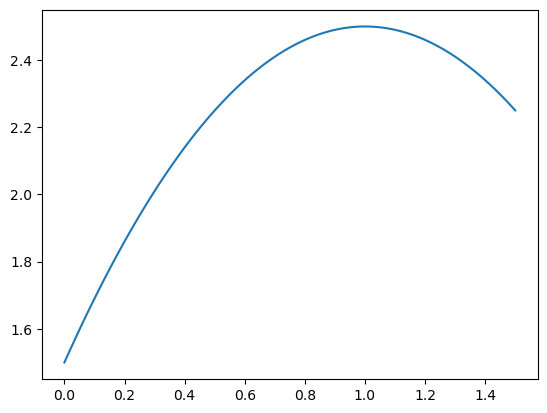

In [110]:
xs = np.linspace(0, 1.5, 100)
sxs = [shortx(np.array([1,1+3]), np.array([2,2+3]),x, verbose=1) for x in xs]
plt.clf()
plt.plot(xs, sxs)

5.5


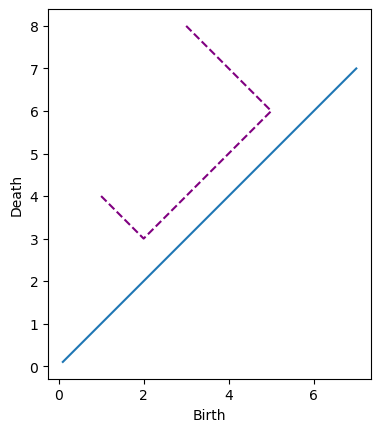

In [101]:
d = shortx(np.array([1,4]), np.array([3,8]),1, verbose=1)
print(d)
plt.plot([0.1,7],[0.1,7])
plt.xlabel("Birth")
plt.ylabel("Death")
plt.gca().set_aspect('equal')
plt.show()

## Figure

In [223]:
n1, n2 = int((rng.random()+2)*10), int((rng.random()+2)*10)
pdF, pdG = rand_PD(n1), rand_PD(n2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [ 9 10 11 12 13 14 15 16 17 18 19 20 21  6  4  1  7  0  5  3  2  8]


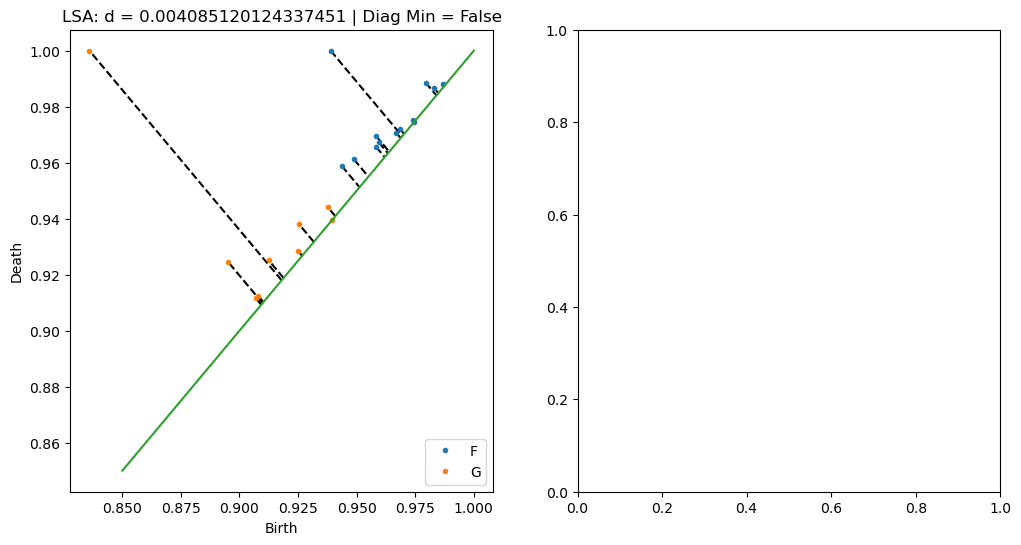

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for myi, my in enumerate([False]):
    plt.sca(axs[myi])
    
    mat = np.zeros((n1+n2,n1+n2))
    for i in range(n1+n2):
        for j in range(n1+n2):
            if i < n1: 
                if j < n2: 
                    mat[i][j] = short(pdF[i], pdG[j], miny=my)
                else:
                    mat[i][j] = diag(pdF[i])
            elif j < n2: 
                mat[i][j] = diag(pdG[j])
    np.savetxt("./mat.csv", mat, delimiter=",")
    row, col = scipy.optimize.linear_sum_assignment(mat)
    print(row, col)
    
    sm = 0
    for i in range(n1+n2):
        sm += mat[row[i], col[i]]
        a = pdF[row[i]] if row[i] < n1 else None
        b = pdG[col[i]] if col[i] < n2 else None
        if a is None and b is None: continue
    
        if a is not None and b is not None: 
            short(a, b, miny=my, verbose=1)
        else:
            if a is None:
                a = diag_proj(b)
            elif b is None:
                b = diag_proj(a)
            plt.plot([a[0], b[0]], [a[1], b[1]], '--', color='black')
        
        
    
        # plt.plot([a[0], b[0]], [a[1], b[1]], '--', color="grey")
    
    plt.plot(pdF[:,0],pdF[:,1], '.', label="F")
    plt.plot(pdG[:,0],pdG[:,1], '.', label="G")
    plt.plot([0.85,1],[0.85,1])

    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.title(f"LSA: d = {sm} | Diag Min = {my}")
plt.legend()
# plt.gca().set_aspect('equal', adjustable='box')
# plt.axis('scaled')
plt.show()

## Mathematica

In [19]:
cb = np.array([[1,1],[1,-1]])/np.sqrt(2)
def decomp(a,b):
    md = a+(cb@(b-a))[0]*np.array([1,1])/np.sqrt(2)
    return straight(a, md)+straight(md,b), md
# (1/8)*(-2*(a[0]-a[1])*np.abs(a[0]+a[1]-b[0]-b[1])+(-a[0]+a[1]-b[0]+b[1])*np.abs(a[0]-a[1]-b[0]+b[1]))
# (1/8)*(2*np.diff(a)*np.abs(np.sum(a)-np.sum(b))+(np.diff(a)+np.diff(b))*np.abs(np.diff(b)-np.diff(a)))[0]

In [56]:
decomp(a, bs[0])

(5.0222143102663726, array([3.35640637, 4.35640637]))

(-3.0, 10.0)

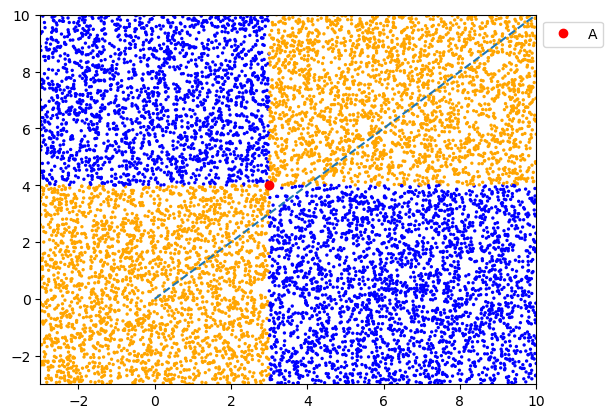

In [72]:
up = lambda a,b: 2*(a[1]-a[0])*max(np.abs(a[0]-b[0]),np.abs(a[1]-b[1]))
down = lambda a,b: 2*(a[1]-a[0])*np.abs(a[0]+a[1]-b[0]-b[1])

a = np.array([3,4])
bs = []
c, mc = 0, 10000
while c < mc:
    b = np.random.rand(2,)*13-3
    # if b[1] < b[0]: continue
    bs.append(b)
    c += 1

bs = np.array(bs)

plt.plot([a[0]], [a[1]],"ro",label="A")
plt.scatter(bs[:,0],bs[:,1], s=2, color=[("blue" if up(a,b) >= down(a,b) else "orange") for b in bs])
plt.legend(bbox_to_anchor=(1,1))
plt.plot([0,10],[0,10], '--')
plt.xlim(-3,10)
plt.ylim(-3,10)

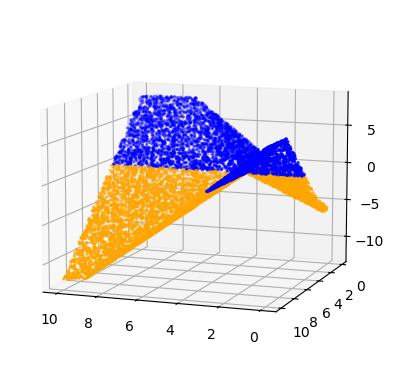

In [88]:
up = lambda a,b: 2*(a[1]-a[0])*max(np.abs(a[0]-b[0]),np.abs(a[1]-b[1]))
down = lambda a,b: 2*(a[1]-a[0])*np.abs(a[0]+a[1]-b[0]-b[1])

a = np.array([3,4])
bs = []
c, mc = 0, 10000
while c < mc:
    b = np.random.rand(2,)*10
    # if b[1] < b[0]: continue
    bs.append(b)
    c += 1

bs = np.array(bs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=110)
# plt.plot([a[0]], [a[1]],"ro",label="A")
ax.scatter(bs[:,0],bs[:,1], [up(a,b)-down(a,b) for b in bs], s=2, color=[("blue" if up(a,b) >= down(a,b) else "orange") for b in bs])
# plt.legend(bbox_to_anchor=(1,1))
# plt.plot([0,10],[0,10], '--')
# plt.xlim(0,10)
# plt.ylim(0,10)

In [ ]:
FractionBox["1", "8"] (-2 (a-b) Abs[a+b-c-d]+(-a+b-c+d) Abs[a-b-c+d]) 
-FractionBox["1", "4"] (a-b+c-d) Max[Abs[a-c],Abs[b-d]] 

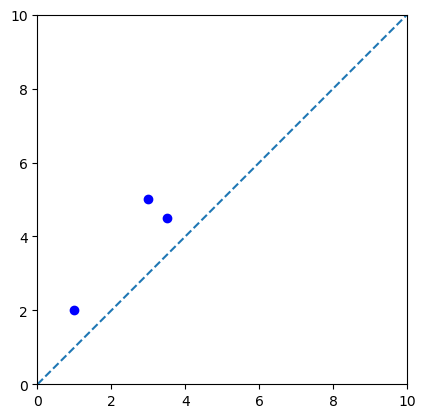

In [25]:
a, b = np.array([1,2]), np.array([3,5])
d, md = decomp(a,b)
plt.plot([a[0],md[0],b[0]],[a[1],md[1],b[1]], 'bo')
plt.plot([0,10],[0,10], '--')
plt.xlim(0,10)
plt.ylim(0,10)
plt.gca().set_aspect('equal')

## Local Min

In [202]:
n = 1000
B = 1000
res = []
for _ in range(B):
    f, g = np.random.rand(2,n)
    ts = np.linspace(0,1,10)
    hs = np.array([len(local_min((1-t)*f+t*g)) for t in ts])
    res.append([np.min(hs), np.max(hs)])

NameError: name 'local_min' is not defined

In [59]:
res = np.array(res)

In [60]:
len(local_min(f)), len(local_min(g))

(331, 343)

In [61]:
np.mean(res, axis=0)

array([326.446, 341.418])

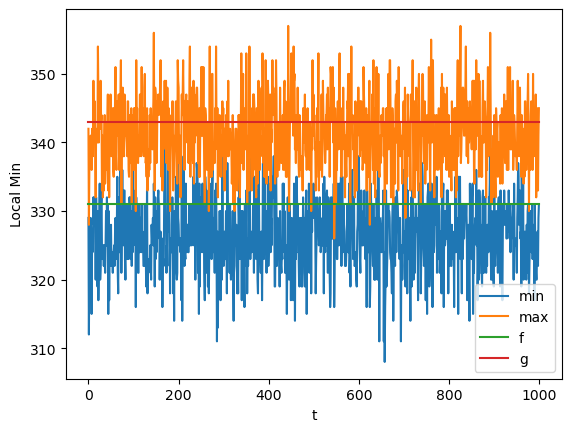

In [62]:
plt.plot(range(B), res[:,0], label="min")
plt.plot(range(B), res[:,1], label="max")
plt.plot([0,B], len(local_min(f))*np.ones(2), label="f")
plt.plot([0,B], len(local_min(g))*np.ones(2), label="g")
plt.xlabel("t")
plt.ylabel("Local Min")
plt.legend()
plt.show()

In [ ]:
from numpy.random import default_rng

def distrib(n, B=1000, ts=np.linspace(0, 1, 100), root_seed=None):
    if root_seed == None: root_seed = rand_seed()

    def run(idx):
        rng = default_rng([idx, root_seed])
        f,g = rng.random((n,n)), rng.random((n,n))
        hs = np.array([t*f+(1-t)*g for t in ts]) 
        vines = vineyard(ts, hs, fmax=1.0, verbose=False)

        pFs = persistence(f, dimension=0), persistence(f, dimension=1)
        pGs = persistence(g, dimension=0), persistence(g, dimension=1)
        
        return [
            np.linalg.norm(f-g,ord=np.inf),
            np.linalg.norm(f-g,ord=1),
            vdist(vines, lambda _: 1, lambda _: 1),
            gudhi.bottleneck_distance(pFs[0], pGs[0]),
            gudhi.wasserstein.wasserstein_distance(pFs[0], pGs[0], internal_p=np.inf, order=1),
            gudhi.bottleneck_distance(pFs[1], pGs[1]),
            gudhi.wasserstein.wasserstein_distance(pFs[1], pGs[1], internal_p=np.inf, order=1),
        ]

    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda b: run(b), range(B))
    return res

In [17]:
def distrib(n, B=1000, ts=np.linspace(0, 1, 100)):
    def run():
        f,g = np.random.rand(n,n), np.random.rand(n,n)
        hs = np.array([t*f+(1-t)*g for t in ts]) 
        vines = vineyard(ts, hs, fmax=1.0, verbose=False)
        dist = vdist(vines, lambda _: 1, lambda _: 1)
        return dist

    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda _: run(), range(B))
    return res

In [18]:
ns = np.arange(0,31,3)[1:]
res = []
for n in ns:
    print(n)
    dists = distrib(n, B=1000)
    res.append(dists)

3
6
9
12
15
18


Process ForkPoolWorker-187:
Process ForkPoolWorker-182:
Process ForkPoolWorker-188:
Process ForkPoolWorker-181:
Process ForkPoolWorker-190:
Process ForkPoolWorker-184:
Process ForkPoolWorker-189:
Process ForkPoolWorker-186:
Process ForkPoolWorker-183:
Process ForkPoolWorker-192:
Process ForkPoolWorker-191:
Process ForkPoolWorker-185:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py",

KeyboardInterrupt: 

  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/tda/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File

In [ ]:
res = np.array(res)

In [ ]:
for i in range(len(ns))[1:]:
    plt.hist(res[i], label=f"n={ns[i]}", alpha=0.75, density=True)
# plt.plot(ns[:3], np.mean(res, axis=1), marker=".")
plt.title("Uniformly Random f/g")
plt.xlabel("Vineyard Distance")
plt.ylabel("Density (%)")
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def model(x, a):
    return a * x**2

popt, pcov = curve_fit(model, ns, np.mean(res, axis=1))

In [ ]:
popt

In [ ]:
plt.plot(ns, np.mean(res, axis=1), marker="o")
plt.plot(ns, model(ns, *popt), label="fit")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Mean Vineyard Distance")
plt.title("Uniformly Random f/g")
plt.show()

In [ ]:
plt.plot(ns, np.std(res, axis=1, ddof=1)**2, marker="o")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Variance of Vineyard Distance")
plt.title("Uniformly Random f/g")
plt.show()

In [245]:
def distribW(n, B=1000, ts=np.linspace(0, 1, 100)):
    def run():
        f,g = np.random.rand(n,n), np.random.rand(n,n)
        dist = gudhi.bottleneck_distance(persistence(f, dimension=1), persistence(g, dimension=1))
        return dist

    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda _: run(), range(B))
    return res

In [246]:
%%time
ns = np.linspace(1, 100, 50, dtype=int)
resW = []
for n in ns:
    print(f'\rn = {n}', end='', flush=True)
    dists = distribW(n, B=1000, dim=0)
    resW.append(dists)
resW = np.array(resW)

n = 100CPU times: user 1.59 s, sys: 2.26 s, total: 3.85 s
Wall time: 1min 50s


In [248]:
from scipy.optimize import curve_fit

# def model(x, a,b):
#     return b*np.exp(a*np.log(x))
# def model(x, a,b,c):
#     return b/((x**c)*(np.exp(a/x)-1))
# def model(x, a,b,c):
#     return stats.gamma(a, scale=1/b).pdf(x)
def model(x, a,b,c,d):
    return b/((x**c)*(np.exp(a/x)-1)+(x**d))

popt, pcov = curve_fit(model, ns[:], np.mean(resW, axis=1)[:])

$$E[W_\infty(f,g)]\approx \frac{7}{x^{3/2}(e^{9/x}-1)}$$
$$\approx \frac{b}{x^c(e^{a/x}-1)+x^d}$$

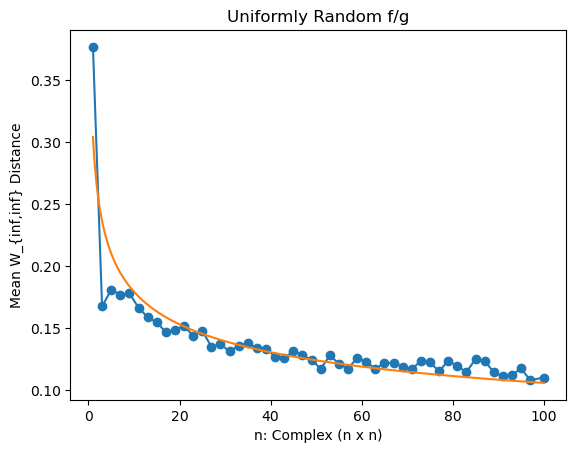

In [249]:
ns_plot = np.linspace(np.min(ns), np.max(ns), 1000)
plt.plot(ns, np.mean(resW, axis=1), marker="o")
plt.plot(ns_plot, model(ns_plot, *popt), label="fit")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Mean W_{inf,inf} Distance")
plt.title("Uniformly Random f/g")
plt.show()

In [250]:
popt, pcov = curve_fit(model, ns[:], np.std(resW, axis=1, ddof=1)**2)

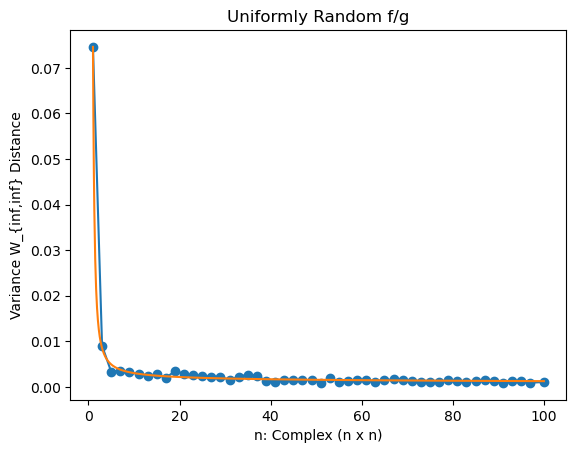

In [251]:
plt.plot(ns, np.std(resW, axis=1, ddof=1)**2, marker="o")
plt.plot(ns_plot, model(ns_plot, *popt), label="fit")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Variance W_{inf,inf} Distance")
plt.title("Uniformly Random f/g")
plt.show()

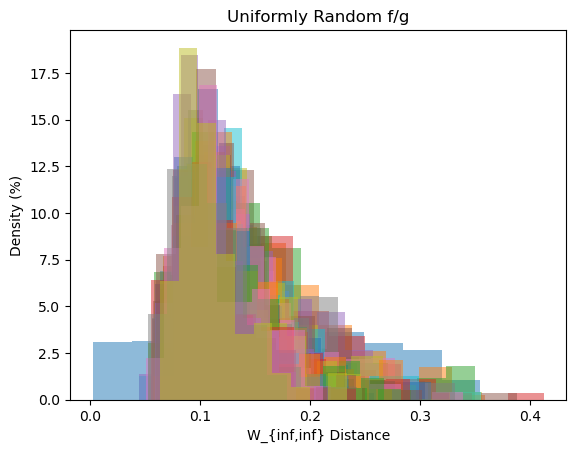

In [252]:
for i in range(len(ns))[1:]:
    plt.hist(resW[i], label=f"n={ns[i]}", alpha=0.5, density=True)
# plt.plot(ns[:3], np.mean(res, axis=1), marker=".")
plt.title("Uniformly Random f/g")
plt.xlabel("W_{inf,inf} Distance")
plt.ylabel("Density (%)")
#plt.legend()
plt.show()

In [253]:
def model(x, a,b):
    return stats.gamma(a, scale=1/b).cdf(x)

resG = []
for i in range(len(ns)):
    ecdf = stats.ecdf(resW[i])
    if ns[i] < 2: continue
    popt, pcov = curve_fit(model, ecdf.cdf.quantiles, ecdf.cdf.probabilities)
    resG.append([ns[i], *popt])
    #res_plot = np.linspace(np.min(resW[i]), np.max(resW[i]), 100)
    # print(ns[i])
    # plt.hist(resW[i], density=True)
    # plt.plot(res_plot, stats.gamma(popt[0], scale=1/popt[1]).pdf(res_plot))
    # plt.show()
    # plt.plot(ecdf.cdf.quantiles, ecdf.cdf.probabilities)
    # plt.plot(ecdf.cdf.quantiles, [model(q, *popt) for q in ecdf.cdf.quantiles])
    #plt.show()
    # break

Text(0.5, 1.0, 'Gamma(a,b) fit')

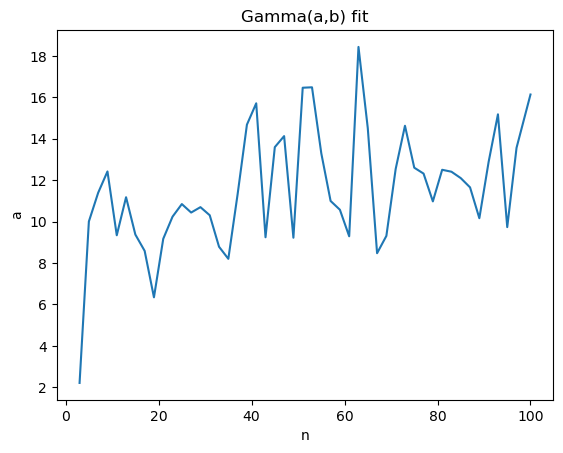

In [254]:
resG = np.array(resG)
plt.plot(resG[:,0], resG[:,1])
plt.ylabel("a")
plt.xlabel("n")
plt.title("Gamma(a,b) fit")

Text(0.5, 0, 'n')

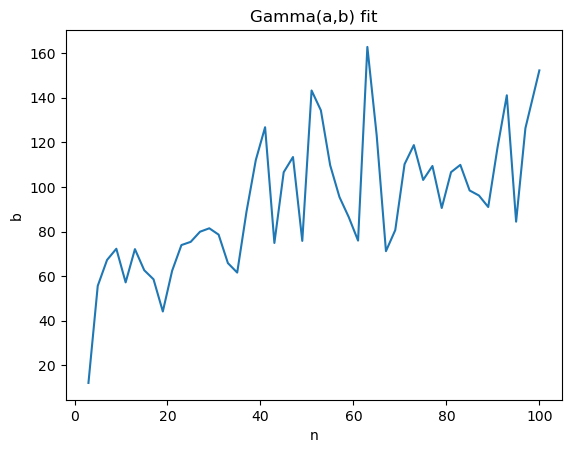

In [255]:
plt.plot(resG[:,0], resG[:,2])
plt.ylabel("b")
plt.title("Gamma(a,b) fit")
plt.xlabel("n")

In [425]:
def rand_seed():
    return int(np.random.rand()*1e5)

In [435]:
from numpy.random import default_rng

def distribWr(n, B=1000, ts=np.linspace(0, 1, 100), root_seed=None):
    if root_seed == None: root_seed = rand_seed()
    def run(idx):
        rng = default_rng([idx, root_seed])
        rand_PD = lambda : np.sort(rng.random((n,2)), axis=1) # filtration 0-1
        dist = gudhi.bottleneck_distance(rand_PD(), rand_PD())
        return dist
    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda i: run(i), range(B))
    return res

In [443]:
%%time
ns = np.linspace(1, int(1e2), 100, dtype=int)
resWr = []
for n in ns:
    print(f'\rn = {n}', end='', flush=True)
    dists = distribWr(n, B=100, root_seed=rand_seed())
    resWr.append(dists)
resWr = np.array(resWr)

n = 100CPU times: user 2.2 s, sys: 4.75 s, total: 6.95 s
Wall time: 8.87 s


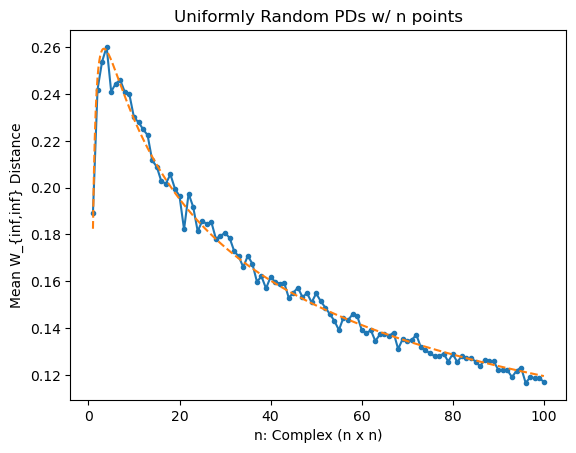

In [456]:
def model(x, a,b,c,d):
    return b/((x**c)*(np.exp(a/x)-1)+(x**d))
popt, pcov = curve_fit(model, ns[:], np.mean(resWr, axis=1)[:])
ns_plot = np.linspace(np.min(ns), np.max(ns), 1000)
plt.plot(ns, np.mean(resWr, axis=1), marker=".")
plt.plot(ns_plot, model(ns_plot, *popt), '--', label="fit")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Mean W_{inf,inf} Distance")
plt.title("Uniformly Random PDs w/ n points")
plt.show()

[0.89470583 0.02811357 1.28363951 0.9321498 ]


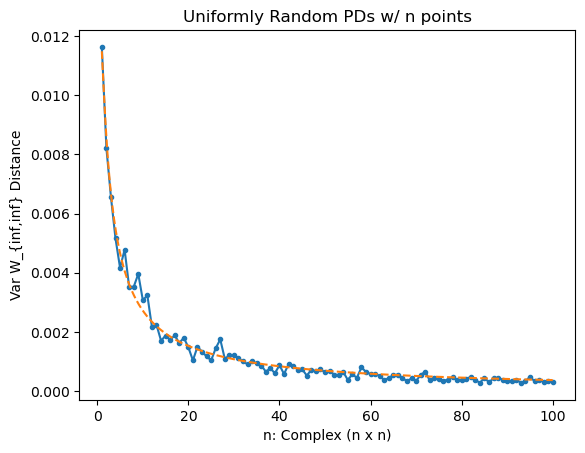

In [464]:
def model(x, a,b,c,d):
    return b/((x**c)*(np.exp(a/x)-1)+(x**d))
    # return a*np.exp(-b*x)
popt, pcov = curve_fit(model, ns[:], np.std(resWr, axis=1, ddof=1)[:]**2)
print(popt)
ns_plot = np.linspace(np.min(ns), np.max(ns), 1000)
plt.plot(ns, np.std(resWr, axis=1, ddof=1)[:]**2, marker=".")
plt.plot(ns_plot, model(ns_plot, *popt), '--', label="fit")
plt.xlabel("n: Complex (n x n)")
plt.ylabel("Var W_{inf,inf} Distance")
plt.title("Uniformly Random PDs w/ n points")
plt.show()

In [66]:
from numpy.random import default_rng

def distrib(n, B=1000, ts=np.linspace(0, 1, 100), root_seed=None):
    if root_seed == None: root_seed = rand_seed()

    def run(idx):
        rng = default_rng([idx, root_seed])
        f,g = rng.random((n,n)), rng.random((n,n))
        hs = np.array([t*f+(1-t)*g for t in ts]) 
        vines = vineyard(ts, hs, fmax=1.0, verbose=False)

        pFs = persistence(f, dimension=0), persistence(f, dimension=1)
        pGs = persistence(g, dimension=0), persistence(g, dimension=1)
        
        return [
            np.linalg.norm(f-g,ord=np.inf),
            np.linalg.norm(f-g,ord=1),
            vdist(vines, lambda _: 1, lambda _: 1),
            gudhi.bottleneck_distance(pFs[0], pGs[0]),
            gudhi.wasserstein.wasserstein_distance(pFs[0], pGs[0], internal_p=np.inf, order=1),
            gudhi.bottleneck_distance(pFs[1], pGs[1]),
            gudhi.wasserstein.wasserstein_distance(pFs[1], pGs[1], internal_p=np.inf, order=1),
        ]

    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda b: run(b), range(B))
    return res

In [112]:
%%time
ns = np.linspace(1, int(30), 30, dtype=int)
res = []
for n in ns:
    print(f'\rn = {n}', end='', flush=True)
    dists = distrib(n, B=100, root_seed=rand_seed())
    res.append(dists)
res = np.array(res)

n = 30CPU times: user 1.16 s, sys: 1.34 s, total: 2.5 s
Wall time: 2min 4s


In [113]:
res = np.array(res)

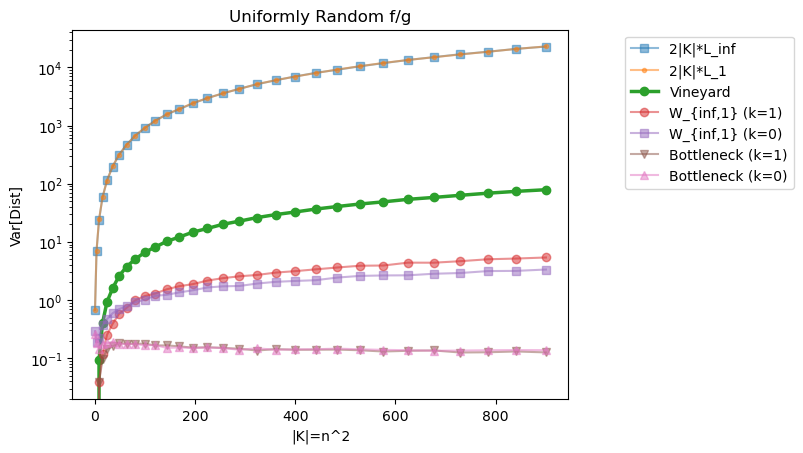

In [118]:
mres = np.mean(res, axis=1).T
# mres = (np.std(res, axis=1, ddof=1)**2).T
a = 0.5
plt.plot(ns**2, 2*(ns**2)*mres[0], marker="s", markersize=6, alpha=a, label="2|K|*L_inf")
plt.plot(ns**2, 2*(ns**2)*mres[1], marker=".", markersize=6, alpha=a, label="2|K|*L_1")
plt.plot(ns**2, mres[2], marker="o", markersize=6, linewidth=2.5, alpha=1, label="Vineyard")

plt.plot(ns**2, mres[6], marker="o", markersize=6, alpha=a, label="W_{inf,1} (k=1)")
plt.plot(ns**2, mres[4], marker="s", markersize=6, alpha=a, label="W_{inf,1} (k=0)")
plt.plot(ns**2, mres[5], marker="v", markersize=6, alpha=a, label="Bottleneck (k=1)")
plt.plot(ns**2, mres[3], marker="^", markersize=6, alpha=a, label="Bottleneck (k=0)")

# plt.plot(ns, model(ns, *popt), label="fit")
plt.xlabel("|K|=n^2")
plt.yscale('log')
plt.ylabel("Var[Dist]")
plt.title("Uniformly Random f/g")
plt.legend(bbox_to_anchor=(1.1,1.00))
plt.show()

In [26]:
def distribLp(n, p=1, B=1000, ts=np.linspace(0, 1, 100)):
    def run():
        f,g = np.random.rand(n,n), np.random.rand(n,n)
        return np.linalg.norm((f-g).flatten(), ord=p)

    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda _: run(), range(B))
        
    return res

In [55]:
n = 50**2
mom_m = lambda m: 2/((m+2)*(m+1))
h = lambda p: lambda x: (n*x)**(1/p)
hder = lambda p: lambda x: ((n)**(1/p))*(x**(1/p-1.))/p

In [56]:
ps = np.arange(1,5)
res = []
for p in ps:
    runs = distribLp(int(np.sqrt(n)), B=int(1e5), p=p)
    res.append(runs)

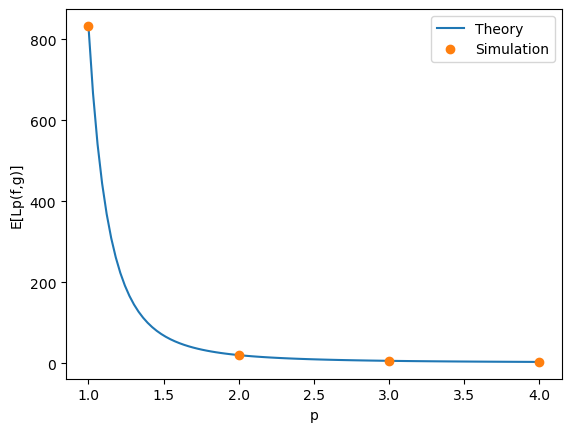

In [57]:
ps_plot = np.linspace(np.min(ps), np.max(ps), 100)
res = np.array(res)
plt.plot(ps_plot, [(2*n/((p+2)*(p+1)))**(1/p) for p in ps_plot], label="Theory")
plt.plot(ps, np.mean(res, axis=1), "o", label="Simulation")
plt.xlabel("p")
plt.ylabel("E[Lp(f,g)]")
plt.legend()
plt.show()

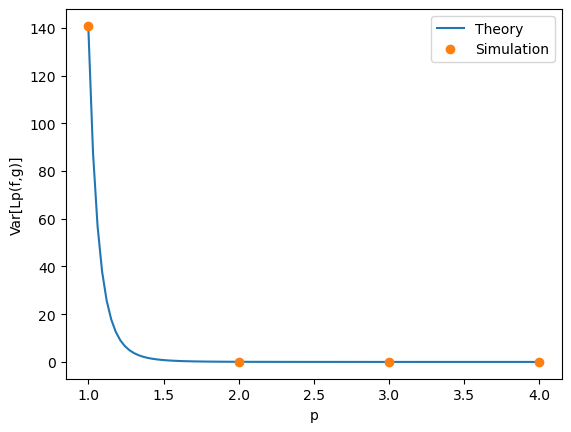

In [85]:
ps_plot = np.linspace(np.min(ps), np.max(ps), 100)
#plt.plot(ps_plot, [(1/n)*((hder(p)(mom_m(p)))**2)*(mom_m(2*p)-(mom_m(p)**2)) for p in ps_plot], label="Theory")
plt.plot(ps_plot, [(2*n/((p+2)*(p+1)))**(2/p)*((p+5)/(4*n*(2*p+1))) for p in ps_plot], label="Theory")

plt.plot(ps, np.std(res, axis=1)**2, "o", label="Simulation")
plt.xlabel("p")
plt.ylabel("Var[Lp(f,g)]")
plt.legend()
plt.show()

In [92]:
n

2500

In [341]:
runs = distribLp(int(np.sqrt(n)), B=int(1e6), p=np.inf)
print(np.std(runs, ddof=1)**2)

0.019425163041845994


In [109]:
scipy.integrate.quad(lambda a,n: 2*n*((a*(2-a))**(n-1))*(1-a), 0, 1, args=(1.1,))[0]

1.0000000000000002

In [429]:
ns = np.linspace(1, int(1e6), 100)
ev_n = lambda nv: scipy.integrate.quad(lambda a,n: a*2*n*((a*(2-a))**(n-1))*(1-a), 0, 1, args=(nv,))[0]
evs = np.vectorize(ev_n)(ns)

In [430]:
#term = lambda n, k: ((-1)**k)*2**(n-k)*scipy.special.binom(n-1,k)/((n+k+2)*(n+k+1))
#ev_ns = lambda n: n*sum([term(n, k) for k in range(n)])
ev_2f1 = lambda n: n*scipy.special.exp2(n)/((n+2)*(n+1)) * scipy.special.hyp2f1(1-n,1+n,3+n,1/2)
evs_s = [ev_2f1(int(n)) for n in ns]

In [433]:
from scipy.optimize import curve_fit

def model(x, a):
    return a * x

popt, pcov = curve_fit(model, ns, evs)

In [434]:
1-pcov

array([[1.]])

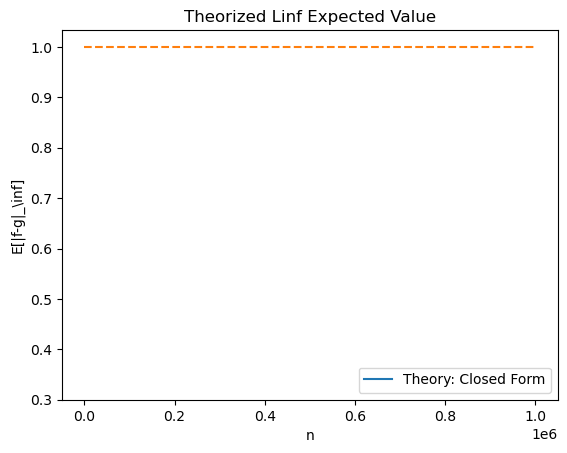

In [435]:
#plt.plot(ns, evs, label="Theory:  EV")
plt.plot([int(n) for n in ns], evs_s, label="Theory: Closed Form")
#plt.plot(ns, [model(n, popt[0]) for n in ns], label="{:0.4f}*x".format(popt[0]))
plt.plot([0,np.max(ns)], [1,1], '--')
plt.xlabel("n")
plt.ylabel("E[|f-g|_\inf]")
plt.title("Theorized Linf Expected Value")
plt.legend()
plt.show()

In [291]:
def distrib(n, B=1000, ts=np.linspace(0, 1, 100)):
    def run():
        f,g = np.random.rand(n,n), np.random.rand(n,n)
        hs = np.array([t*f+(1-t)*g for t in ts]) 
        vines = vineyard(ts, hs, verbose=False)
        #dist = vdist(vines, lambda _: 1, lambda _: 1)

        vinet = np.array([[vine[0][0],vine[-1][0]] for vine in vines])
        if vinet.shape[0] == 0: return np.zeros_like(ts)
            
        coverage = [np.sum((vinet[:,0] <= t) & (vinet[:,1] >= t))/(n*n) for t in ts]
        return coverage
        
    pool = mp.Pool(mp.cpu_count())
    res = pool.map(lambda _: run(), range(B))
    return res

In [292]:
ns = np.arange(0,31,3)[1:]
res = []
for n in ns:
    print(n)
    dists = distrib(n, B=100)
    res.append(dists)
res = np.array(res)

3
6
9
12
15
18
21
24
27


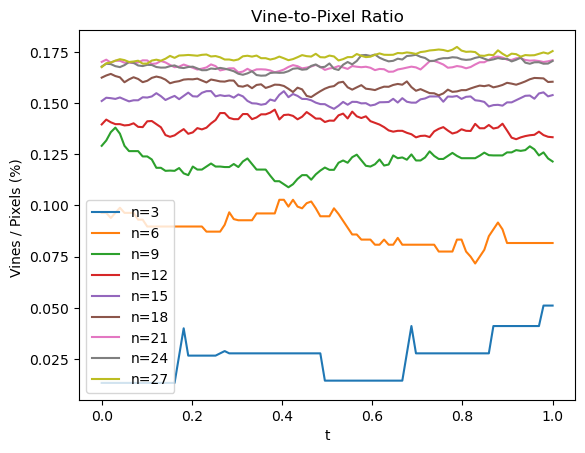

In [294]:
covs = np.mean(res, axis=1)
for i,n in enumerate(ns):
    plt.plot(np.linspace(0, 1, 100), covs[i], label=f"n={n}")

plt.xlabel("t")
plt.ylabel("Vines / Pixels (%) ")
plt.title("Vine-to-Pixel Ratio")
plt.legend()
plt.show()

In [266]:
res = np.array(res)
plt.plot(ns, np.mean(res, axis=1)/(ns*ns), marker="o")
# plt.plot(ns, model(ns, *popt), label="fit")


KeyboardInterrupt: 